Zoher Ghadyali and Kyle Flores

SigSys 2015

PS09

March 1, 2015

Below are the helper functions we were provided with for this assignment. In addition, we import several packages that we need to run our generate_bpsk_signal().

In [1]:
% matplotlib inline

from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as mplib
import thinkdsp
from array import array

# This function converts a string into a numpy array of bits
# note that it is assumed that each character is 7 bits long here
def string2NPArray(s):
    bits = np.array([])
    for a in bytearray(s, 'ascii'):
        for b in range(0,7):
            bits = np.append(bits,float((a>>(7-b-1))&1))
    return bits

# This function converts a numpy array of bits to a string
# note that it is assumed that each character is 7 bits long here
def NPbits2String(bits):
    S = ""
    for a in np.arange(0, np.ceil(len(bits)/7)):
        tmp = 0
        for k in np.arange(0,7):
            b = bits[a*7+k]
            tmp = tmp + (2**(6-k))*b
        S = S + chr(int(tmp))
    return S

# this function is used to help convert numpy array data into a format
# suitable for writing into a wave file
def convert_to_int16(sig):
    # convert into int16  to write as wave
    sig = (sig/np.max(sig))*(2**14)
    sig = sig.astype('int16')
    return sig
    

# this is a utility function that  finds the start and  end 
# of transmission in the numpy array of samples xf
# The function looks for the first instance where the entries of xf
# go above threshold and returns the index into xf where this happens
# in start_idx
# The function looks for the last instance where the entries of xf
# are above threshold and returns the index into xf where this happens
# in end_idx
# 
# You will probably have to do some trial and error to get the threshold right
# one possibility is to se the threshold equal to some factor of the maximum value
# in the input signal,  e.g. 0.3 * maximum value in xf
#
def find_start_and_end(xf, threshold = 2000): 
    import numpy as np    
    start_idx = -1
 
    for k in range(0, len(xf)):
        if(np.abs(xf[k])) > threshold:
            start_idx = k
            break

    if(start_idx  < 0):
        print "Unable to detect start of transmission"
        return -1
    
    end_idx = -1
    
    for k in range(0, len(xf)):
        if(np.abs(xf[len(xf)-k-1])) > threshold:
            end_idx = len(xf)-k-1
            break

    if(end_idx < 0):
        print "Unable to detect end of transmission"
        return -1

    return start_idx, end_idx

    

bpsk is a module that is provided as python bytecode. bpsk.help() provides the syntax and definitions of the parameters of the functions that are included in the bpsk module

In [2]:
import bpsk

bpsk.help()

This module provides:

     generate_bpsk_signal(bits, rate=8000, symbol_len = 250, freq = 1000):
         Returns a numpy array which is a BPSK encoding of bits
         1 symbol worth of zeros are added at the beginning and the end to aid detection of transmission start
         A 1 bit is added to the beginning to help with synchronization
         bits -  a numpy array of 1s and 0s
         rate - sample rate used
         symbol_len - length in samples of the rectangular pulse used to encode the bits
         freq - carrier frequency in Hz

     decode_bpsk_signal(x, freq=1000, rate = 8000, symbol_len = 250, detection_threshold_factor = 0.3, LPFbw = 320):
         Decodes a received BPSK signal in vector x and produces a numpyarray of bits 
         The function uses a brute-force approach to carrier phase synchronization by checking 16 evenly spaced
         phase offsets between -pi and pi to find the one which results in the strongest demodulated signal
         which is then u

From the bpsk help above, we know the genrate_bpsk_signal has 4 inputs and should take an array of bits and convert it into a signal by multiplying a square wave with a high frequency cosine. Below is our implementation of generate bpsk_signal().

In [3]:
def generate_bpsk_signal(bits, rate=8820, symbol_len=250, freq=1000):
    """This function has 4 inputs. bits is an array of bits that encodes the desired string that is being transmitted.
    rate is the sampling rate of the signal in Hz. The signal is sampled every 1/8820 seconds. The symbol length is 
    the length of a single bit in the signal. A 1 is 250 samples long, as is a 0. freq is the frequency in Hz of the 
    cosine that is multiplied by the square wave.
    The outputs are an array of ts the signal is evaluated at and x is the signal itself.
    """
    
    bits = np.insert(bits, 0, np.array([1]))  #here we insert our header bit, which is a 1 bit that is not part of the
    #encoded string
    x = np.array([])
    for i in range(0, len(bits)):
        if bits[i] == 1.0:
            x = np.append(x, 7500*np.ones(symbol_len))  #we go through each bit and expand it to meet the symbol len
        if bits[i] == 0.0:
            x = np.append(x, -7500*np.ones(symbol_len)) #the scale factor is just to make the signal sound the same as
            #the solution provided for the transmitter
            
    ts = np.arange(0, len(x)/float(rate), 1/float(rate)) #set up our array of ts that the signal is evaluated at
    w = 2*np.pi*freq #convert freq from Hz to radians
    x *= np.cos(w*ts) #multiply by a high frequency cosine that is discontinuous when the bit value changes
    
    return (ts, x)

In the cell below, are function is called and the resulting signal is plotted against time.

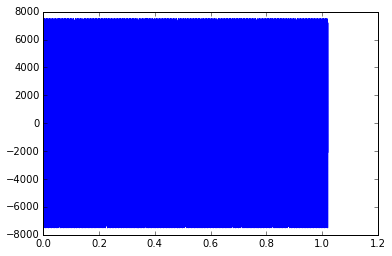

In [4]:
transmit = generate_bpsk_signal(string2NPArray("Hello"))  #call our function with the bits array from string2NPArray
ts = transmit[0]
x = transmit[1]

mplib.plot(ts, x)
mplib.show()

In the cell below, the array that contains our modulated signal, x, is converted into a .wav file. We then played this .wav file over one computer's speakers and recorded it using Audacity on our second computer. You can use the play button below to hear the signal that is transmitted.

In [5]:
wavfile.write('AcousticModemTx_ZG.wav', 8820, convert_to_int16(x))

wave = thinkdsp.read_wave('AcousticModemTx_ZG.wav')
wave.normalize()
wave.make_audio()

Using Audacity, we recorded the transmission above. We then implemented the function below, decode_bpsk_signal(), to decode the recieved bpsk signal. decode_bpsk_signal takes 6 inputs where x is an array of the recieved audio signal, freq is the frequency of the carrier cosine signal, rate is the sample rate, symbol_len is the length of a single bit in the signal, detection_threshold_factor is used for detecting where the signal is in the recording, and LPFbw is the bandwidth of the low-pass filter that is used to reclaim the original signal.

In [6]:
def decode_bpsk_signal(x, freq=1000, rate = 8000, symbol_len = 250, detection_threshold_factor = 0.3, LPFbw = 320):
    """
     Decodes a received BPSK signal in vector x and produces a numpyarray of bits 
     The function uses a brute-force approach to carrier phase synchronization by checking 16 evenly spaced
     phase offsets between -pi and pi to find the one which results in the strongest demodulated signal
     which is then used as the demodulated signal
     The first bit is assumed to be a control bit that always equals 1. This bit is not returned in the final output
     x - a numpy array of the received audio samples
     freq - carrier frequency 
     rate - sample rate used 
     symbol_len - length in samples of the rectangular pulse
     detection_threshold_factor - this is used for detecting the start and end of transmission
                                  the start of transmission is the first sample that exceeds
                                  detection_threshold_factor times the maximum value in x
                                  the end of transmission is the last sample that exceeds
                                  detection_threshold_factor times the maximum value in x
     LPFbw - this is the bandwidth in rad/sec of the low-pass filter that is used after
             multiplying with a cosine
    """
    w = 2*np.pi*freq
    ts = np.arange(0, len(x)/float(rate), 1/float(rate))
    offsets=np.linspace(-np.pi,np.pi,16)
    max_amps=np.empty(16)
    for p in range(len(offsets)): #Loop selects best phase offset.
        tmp=x*np.cos(w * (ts - offsets[p]))
        max_amps[p]=tmp.max()
    phi=offsets[max_amps.argmax()]
    
    (start,end)=find_start_and_end(x, threshold = detection_threshold_factor*max_amps.max())
    signal=x[start:end+1] #Use provided function to find start and end.
    ts = np.arange(0, len(signal)/float(rate), 1/float(rate))
    demod=signal*np.cos(w * (ts - phi)) #Multiply by the cosine to demodulate the signal.
    filt=np.fft.ifft(np.fft.fft(demod)*np.concatenate((np.ones(LPFbw),np.zeros(len(demod)-LPFbw)))) #LP with cutoff=LPFbw
    bit_arr=[]
    for c in range((len(filt)/symbol_len)+1): #Iterate through filtered array, symbol_len items at a time.
        avg=np.mean(filt[c*symbol_len:(c+1)*symbol_len])
        if avg>0:
            bit_arr.append(1)
        elif avg<=0:
            bit_arr.append(0)
    
    return (ts,filt,np.array(bit_arr[1:],dtype=np.float32))

Below is the recieved signal that we recorded using Audacity. We attempted to use the mic but it was picking up too much noise, causing our signal to be obscured by noise.

In [13]:
wave = thinkdsp.read_wave('AcousticModem_OTA.wav')
wave.normalize()
wave.make_audio()

The outputs of the decode_bpsk_signal() are an array of ts, the filtered signal, and the array of bits that, when converted back into a string, will produce the initial message. Using these outputs, the bit array is then passed into the NPbits2String() function. Below is the recieved and decoded message.

In [14]:
fs, x = wavfile.read('AcousticModem_OTA.wav') #This file recorded in Audacity from mic and saved as wav.
(time,filtered,bits) = decode_bpsk_signal(x, freq=1000, rate = fs, symbol_len = 250, detection_threshold_factor = 0.3, LPFbw = 320)
message_string = NPbits2String(bits)
print message_string

Hello


Below is a plot of the recieved signal.

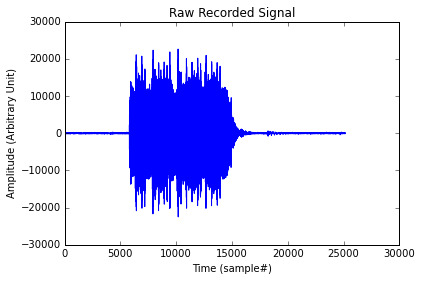

In [8]:
fig=mplib.figure()
ax = fig.add_subplot(111)
ax.set_title('Raw Recorded Signal')
ax.set_xlabel('Time (sample#)')
ax.set_ylabel('Amplitude (Arbitrary Unit)')
mplib.plot(x)
mplib.show()

Below is a plot of the demodulated and filtered signal.

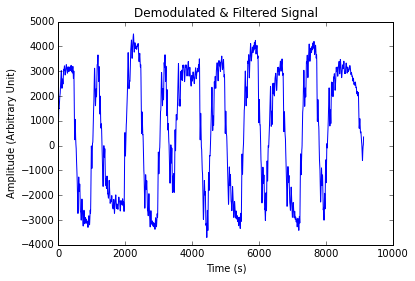

In [11]:
fig=mplib.figure()
ax = fig.add_subplot(111)
ax.set_title('Demodulated & Filtered Signal')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (Arbitrary Unit)')
mplib.plot(filtered)
mplib.show()

Below is a plot of the bits we decoded from our demodulated and filtered signal.

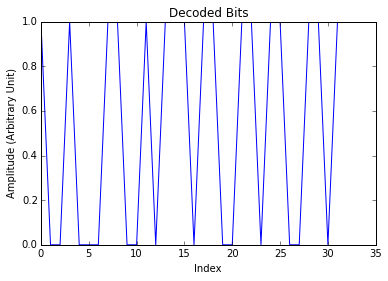

In [10]:
fig=mplib.figure()
ax = fig.add_subplot(111)
ax.set_title('Decoded Bits')
ax.set_xlabel('Index')
ax.set_ylabel('Amplitude (Arbitrary Unit)')
mplib.plot(bits)
mplib.show()